<h1 > Importing Modules</h1>

In [3]:
import tensorflow_datasets as tfds 
import tensorflow as tf 
import math
import numpy as np
import matplotlib.pyplot as plt

<h1 >Loading the MNIST data from keras.datasets</h1>

In [4]:
dataset,metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

<h1 style=color:red>pre process</h1>

<h2>change grey value from int to float</h2>

In [5]:
def normalize(images,labels):
  images = tf.cast(images ,tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

<h1 > Re-shape & show the images</h1>

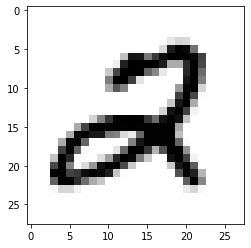

In [6]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image,cmap=plt.cm.binary)
plt.show()

<h1> Take Sample With 25 Images</h1>

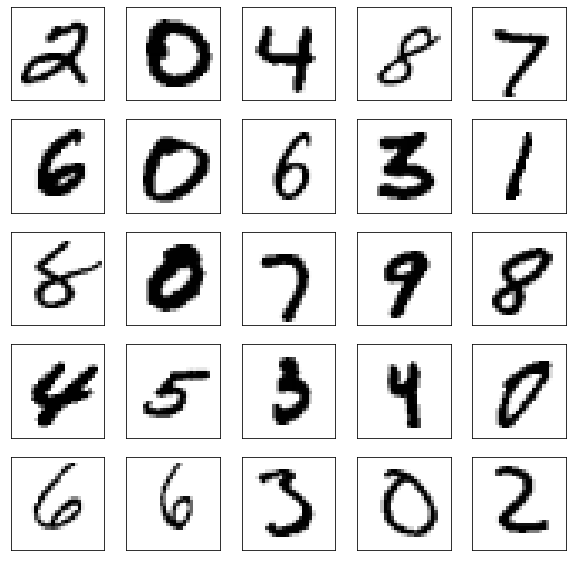

In [7]:
plt.figure(figsize=(10,10))
i = 0
for(image,label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image,cmap=plt.cm.binary)
  i+=1

plt.show()

<h2> Define Batch Size: that defines the number of samples to work through before updating the internal model parameters. and shuffle them</h2>

In [8]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(60000).batch(BATCH_SIZE)
test_dataset  = test_dataset.cache().batch(BATCH_SIZE)

In [9]:
print(train_dataset)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


![Image](cnn.gif)

<h2>
Architecture of a traditional CNNConvolutional neural networks<br></h2>
also known as CNNs, are a specific type of neural networks that are generally composed of the following layers:<br>
<ul>
  <li>The convolution layer</li>
  <li>pooling layer</li>
  <li>flatten layer</li>
</ul>
<p>The model type that we will be using is Sequential<br>
. Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer.<br>
 we can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels).<br>
  The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64)<br></p>
<p>64 in the first layer and 32 in the second layer are the number of nodes in each layer. <br>
This number can be adjusted to be higher or lower, depending on the size of the dataset. In our case, 64 and 32 work well<br>
Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix<br></p>

<h3>Add Dense layers on top</h3><br>
<p>To complete the model, you will feed the last output tensor from the convolutional base  into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D)<br>,
 while the current output is a 3D tensor. First, you will flatten  the 3D output to 1D, then add one or more Dense layers on top,<br>
 so you use a final Dense layer with 10 outputs.</p>

<p><h3>Activation is the activation function for the layer:</h3> <br>
The activation function we will be using for our first 2 layers is the ReLU,<br>
 or Rectified Linear Activation. This activation function has been proven to work well in neural networks.<br>
 there is a ‘Flatten’ layer. Flatten serves as a connection between the convolution and dense layers.<br></p>


In [10]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),

        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu), 
        tf.keras.layers.Dense(10)
    ]
)

<h1>
 <b >Compiling the model</b><br></h1>
<p> we need to compile our model. Compiling the model takes three parameters: optimizer, loss and metrics.<br>
The optimizer controls the learning rate. We will be using ‘adam’ as our optmizer<br>
 Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.<br>
The learning rate determines how fast the optimal weights for the model are calculated.<br>
 A smaller learning rate may lead to more accurate weights (up to a certain point),<br> 
 but the time it takes to compute the weights will be longer.<br>
We will use ‘categorical_crossentropy’ for our loss function. This is the most common choice for classification.<br>
 A lower score indicates that the model is performing better.<br>
To make things even easier to interpret,<br>
 we will use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.<br></p>


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

<h1>Now we will train our model.</h1><br>
<p>To train, we will use the ‘fit()’ <br>
The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, <br>
up to a certain point. After that point, the model will stop improving during each epoch. For our model, we will set the number of epochs to 5.</p>
<h3><b> steps_per_epoch</b></h3>
<p>Assume you have a dataset with 60000 samples (rows of data) and you choose a batch_size = 25 and epochs = 5<br>
This means that the dataset will be divided into (60000/25) = 2400 batches,<br>
 having 32 samples/rows in each batch. The model weights will be updated after each batch.<br>
one epoch will train 2400 batches or 2400 updations to the model.<br>
here steps_per_epoch = no.of batches<br>
With 5 epochs, the model will pass through the whole dataset 5 times.<br></p>




In [13]:
hist = model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(60000/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 55s 26ms/step - loss: 0.1206 - accuracy: 0.9629
Epoch 2/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0385 - accuracy: 0.9883
Epoch 3/5
1875/1875 [==============================] - 50s 26ms/step - loss: 0.0275 - accuracy: 0.9915
Epoch 4/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0204 - accuracy: 0.99362s - loss: 0.020
Epoch 5/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0137 - accuracy: 0.9953


In [14]:
test_loss , test_accuracy = model.evaluate(test_dataset, steps=math.ceil(10000/BATCH_SIZE))

313/313 [==============================] - 3s 10ms/step - loss: 0.0346 - accuracy: 0.9899


<h1> Visualize results</h1>

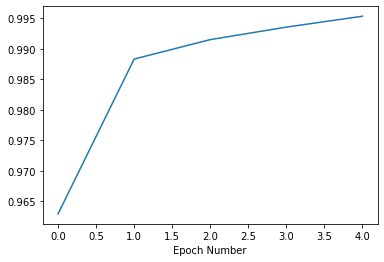

In [15]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
#plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy']);

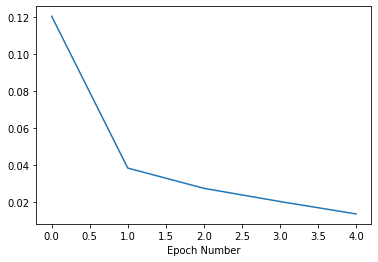

In [16]:
plt.xlabel('Epoch Number')
plt.plot(hist.history['loss']);

<h1>Saving Model</h1>

In [17]:
model.save('model.h5')

<h1>Load Model With Keras format</h1>

In [18]:
model = tf.keras.models.load_model('model.h5')

<h1 >display the architecture of our model so far:</h1>

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

(28, 28)


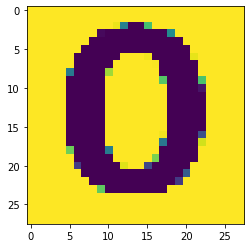

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('test.png', 0)
img = cv2.resize(img, (28, 28))
print (img.shape)
plt.imshow(img)

In [21]:
img = img.reshape((-1, 28,28,1))
print (img.shape)

(1, 28, 28, 1)


 <h1>Predict AN Image </h1>
 <p>The prediction is in the form of a matrix with the numbers of the outputs closest to the prediction,<br>
  then we choose the highest probability and display this result<br></p>
 
 


In [22]:
out = model.predict(img)

In [23]:
max(out[0])

3381.5654

In [24]:
#highest number with highest prediction
np.argmax(out)

3

In [25]:
out

array([[ 2858.4568 , -1795.1691 , -2233.7585 ,  3381.5654 , -4514.6743 ,
        -1035.5887 ,   732.25287, -4198.6577 ,  1799.7356 , -1932.0681 ]],
      dtype=float32)